Feature Engineering and Model Training

Going to make use a recurrent neurel network called LSTM (Long short term memory) for modelling stock price data as the data is sequential. As stock price data is sequential, where each data point depends on the previous ones. RNNs are designed to capture temporal dependencies, making them well-suited for modeling and predicting time series data.

Going to use the stock market prediction using LSTM recurrent neural network paper by Adil Moghar and Mhamed Hamiche as reference (https://www.sciencedirect.com/science/article/pii/S1877050920304865) to make my own model.

In [80]:
# Data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from datetime import datetime

# Data processing
from sklearn.preprocessing import MinMaxScaler

# Model and measure metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Going to create a model for the google stock price dataset

In [81]:
traindf = pd.read_csv('../datasets/GOOG.csv')

testdf = pd.read_csv('../datasets/GOOG_Test.csv')

In [82]:
traindf.Date = pd.to_datetime(traindf['Date'])
traindf = traindf.set_index('Date')

testdf.Date = pd.to_datetime(testdf['Date'])
testdf = testdf.set_index('Date')

In [83]:
traindf = traindf.drop(['Close'], axis='columns')
traindf = traindf.rename(columns={'Adj Close': 'Close'})

In [84]:
train_dates = traindf.index
test_dates = testdf.index

In [85]:
train = np.array(traindf.Close)
test = np.array(testdf.Close)

train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [86]:
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(train)
test = sc.transform(test)

In [87]:
len(train), len(test)

(1510, 251)

Need to convert the data into supervised format for neural network. So data needs to be in (x,y) format where x are the features and y is the target. As time series data is sequential the features x are the number of previous days prices we use to predict next days price.

Going to use past 60 days as features as look back so, x(t-60), x(t-59), ... , x(t-1) will give x(t) which is y(t) 

In [88]:
look_back = 60

In [89]:
def preprocess_data(dataset,step):
    X = []
    Y = []
    for i in range(step, len(dataset)):
        X.append(dataset[i-step:i, 0])
        Y.append(dataset[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

In [90]:
X_train, y_train = preprocess_data(train,look_back)
X_test, y_test = preprocess_data(test, look_back)

In [91]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
46/46 [==============================] - 5s 35ms/step - loss: 0.0207
Epoch 2/100
46/46 [==============================] - 2s 34ms/step - loss: 0.0047
Epoch 3/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0043
Epoch 4/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0040
Epoch 5/100
46/46 [==============================] - 2s 36ms/step - loss: 0.0036
Epoch 6/100
46/46 [==============================] - 2s 36ms/step - loss: 0.0040
Epoch 7/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0036
Epoch 8/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0039
Epoch 9/100
46/46 [==============================] - 2s 36ms/step - loss: 0.0032
Epoch 10/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0032
Epoch 11/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0037
Epoch 12/100
46/46 [==============================] - 2s 36ms/step - loss: 0.0028
Epoch 13/100
46/46 [=====

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [93]:
np.array(train[len(train)-look_back:]).shape

(60, 1)

In [94]:
np.array(test).shape

(251, 1)

In [95]:
predictions = model.predict(X_test)
predictions = sc.inverse_transform(predictions)
test = sc.inverse_transform(test)
train = sc.inverse_transform(train)
train = pd.DataFrame(train, index=train_dates)
test = pd.DataFrame(test, index=test_dates)
predictions = pd.DataFrame(predictions, index=test_dates[look_back:])

predictions

# rmse = np.sqrt(np.mean(((predictions - test) ** 2)))
# rmse


6/6 [==============================] - 1s 12ms/step


,0
Date,
2023-02-08,105.240982
2023-02-09,103.578514
2023-02-10,100.070763
2023-02-13,96.926170
2023-02-14,95.364861
...,...
2023-11-03,127.699348
2023-11-06,128.451782
2023-11-07,129.162384


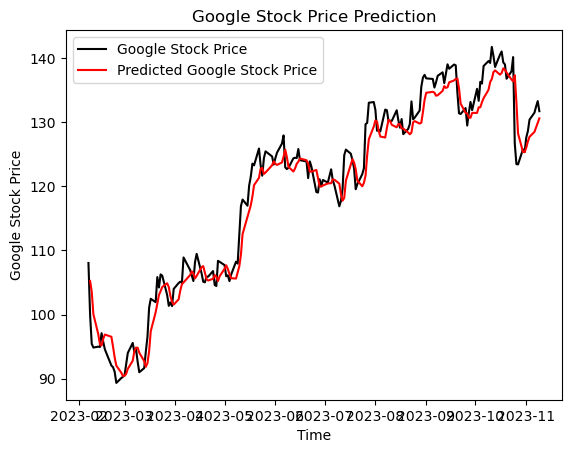

In [96]:
figure, axes = plt.subplots( 1 ) 
#axes.plot(train, color = 'black', label = 'Google Stock Price')

axes.plot(test[59:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

In [97]:
# def predict(day):
#     preds = []
#     prev = train[len(train)-look_back:]
#     i = 0
#     while(i<day):
        
#     return model.predict(lookback)

In [98]:
# t = predict(X_test)
# t = sc.inverse_transform(t)
# t

In [99]:
traindf[len(train)-60:].Close

Date
2022-10-06    102.239998
2022-10-07     99.570000
2022-10-10     98.709999
2022-10-11     98.050003
2022-10-12     98.300003
2022-10-13     99.709999
2022-10-14     97.180000
2022-10-17    100.779999
2022-10-18    101.389999
2022-10-19    100.290001
2022-10-20    100.529999
2022-10-21    101.480003
2022-10-24    102.970001
2022-10-25    104.930000
2022-10-26     94.820000
2022-10-27     92.599998
2022-10-28     96.580002
2022-10-31     94.660004
2022-11-01     90.500000
2022-11-02     87.070000
2022-11-03     83.489998
2022-11-04     86.699997
2022-11-07     88.650002
2022-11-08     88.910004
2022-11-09     87.400002
2022-11-10     94.169998
2022-11-11     96.730003
2022-11-14     96.029999
2022-11-15     98.720001
2022-11-16     98.989998
2022-11-17     98.500000
2022-11-18     97.800003
2022-11-21     95.830002
2022-11-22     97.330002
2022-11-23     98.820000
2022-11-25     97.599998
2022-11-28     96.250000
2022-11-29     95.440002
2022-11-30    101.449997
2022-12-01    101.27